In [1]:
# import model and everything needed to run it
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer

import os
import numpy as np
from copy import deepcopy
from rbm_torch.models.pool_crbm_base import pool_CRBM
from rbm_torch.utils.utils import load_run

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Ari

In [2]:
# load data from preconfigured run file
run_file = "./run_files/toy_pcrbm.json"
run_data, base_config = load_run(run_file)

base_config["model_name"] = run_data["model_name"]
base_config["gpus"] = run_data["gpus"]

model_type = run_data["model_type"]
assert model_type == "pool_crbm"

server_model_dir = run_data["server_model_dir"]
base_config['seed'] = 69

base_config['lgap'] = 0.0
base_config['lbs'] = 0.0
base_config['lcorr'] = 0.0
base_config['ld'] = 0.0
base_config['l1_2'] = 1.0
base_config['epochs'] = 1000

In [3]:
# Training Code for individual model
def train_model(config):
    model = pool_CRBM(config, debug=False, precision=config["precision"])
    logger = TensorBoardLogger(server_model_dir, name=config["model_name"])
    if config["gpus"] > 1:
        # distributed data parallel, multi-gpus on single machine or across multiple machines
        plt = Trainer(max_epochs=config['epochs'], logger=logger, gpus=run_data["gpus"], accelerator="cuda", strategy="ddp", enable_progress_bar=False, enable_model_summary=False)  # distributed data-parallel
    else:
        if config['gpus'] == 0:
            plt = Trainer(max_epochs=config['epochs'], logger=logger, accelerator="cpu", enable_progress_bar=False, enable_model_summary=False)
        else:
            plt = Trainer(max_epochs=config['epochs'], logger=logger, devices=run_data["gpus"], accelerator="cuda", enable_progress_bar=False, enable_model_summary=False)  # gpus=1,
    plt.fit(model)
    return

In [4]:
import tbparse
import pandas as pd
from rbm_torch.analysis import analysis_methods as am

def parse_tb_files_crbm(model_str, model_dir="./", version=None):
    """parses the log directory of a given model, and optionally version. Extracts data to a pandas dataframe for
    easy graphing of our model"""
    checkp, version_dir = am.get_checkpoint_path(model_str, rbmdir=model_dir, version=version)

    # Read in all scalar event files and extract info
    scalars = ["weight_reg", "field_reg", "distance_reg", "gap_reg", "free_energy_diff", "loss", "free_energy_pos", "free_energy_neg", "input_correlation_reg"]
    dfs = []
    for scalar in scalars:
        reader = tbparse.SummaryReader(f"{version_dir}/Train Scalars_{scalar}")
        df = reader.scalars
        rename = {"Train Scalars": scalar}
        df.replace({"tag": rename}, inplace=True)
        dfs.append(df)

    # Read in the main event file and drop almost all the information in it
    reader = tbparse.SummaryReader(version_dir)
    df = reader.scalars
    print(df.keys())

    removal_tags = ["Train Scalars", "Val Scalars", "hp_metric", "train_free_energy_epoch", "val_free_energy_epoch", "ptl/free_energy_diff_step",
                    "val_free_energy_step", "train_free_energy_step", "train_loss_step", "epoch", "train_loss_epoch"]
    rename_tags = {"ptl/train_free_energy_epoch": "train_free_energy_epoch",
                   "ptl/val_free_energy": "val_free_energy"}

    # Everything is Removed except for the Validation Free Energy
    for rtag in removal_tags:
        df.drop(df[df['tag'].str.contains(rtag)].index, inplace = True)

    df.replace({"tag": rename_tags}, inplace=True)

    df = df.iloc[1: , :] # Removes a false 0 step value for the Validation Free Energy
    dfs.append(df)

    df = pd.concat(dfs)  # Join all dfs together
    df.rename(columns={"step": "Epoch", "tag": "Scalar", "value": "Value"}, inplace=True)  # rename columns to epoch
    df.reset_index(inplace=True, drop=True)
    df["Model"] = model_str
    return df

## Define Models

In [24]:
# define several models for comparison across a single variable
vary = "l1_2"
vrange = np.geomspace(1.0, 100000.0, num=10).tolist()
# vrange.insert(0, 0.)
vrange = [round(x, 3) for x in vrange]

model_configs = [deepcopy(base_config) for _ in vrange]

for vid, vval in enumerate(vrange):
    model_configs[vid][vary] = vval
    model_configs[vid]["model_name"] += f"_{vary}_{vid}"

In [23]:
vrange

[1.0, 2.154, 4.642, 10.0, 21.544, 46.416, 100.0, 215.443, 464.159, 1000.0]

In [25]:
# Train Models
cdir = os.getcwd()
os.chdir("/home/jonah/PycharmProjects/phage_display_ML/")

for vid in range(len(vrange)):
    train_model(model_configs[vid])

os.chdir(cdir)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Process Time 0.0029397010803222656


/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Process Time 0.0032989978790283203


/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Process Time 0.0033235549926757812


/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Process Time 0.003022432327270508


/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Process Time 0.0030426979064941406


/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Process Time 0.003322601318359375


/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Process Time 0.003451108932495117


/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Process Time 0.003515005111694336


/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Process Time 0.0033452510833740234


/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Process Time 0.0034139156341552734


/home/jonah/PycharmProjects/phage_display_ML/venv/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.


## Analysis

In [26]:
# Gather Tensorboard Data for all models
dfs = []
for i in range(len(vrange)):
    df = parse_tb_files_crbm(model_configs[i]["model_name"], model_dir="./trained_crbms/")
    dfs.append(df)
df = pd.concat(dfs)  # Join all dfs together

Index(['step', 'tag', 'value'], dtype='object')
Index(['step', 'tag', 'value'], dtype='object')
Index(['step', 'tag', 'value'], dtype='object')
Index(['step', 'tag', 'value'], dtype='object')
Index(['step', 'tag', 'value'], dtype='object')
Index(['step', 'tag', 'value'], dtype='object')
Index(['step', 'tag', 'value'], dtype='object')
Index(['step', 'tag', 'value'], dtype='object')
Index(['step', 'tag', 'value'], dtype='object')
Index(['step', 'tag', 'value'], dtype='object')


(0.0, 0.5)

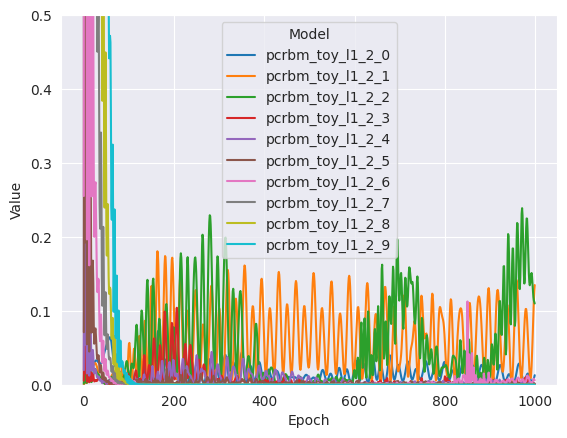

In [27]:
# Plot anything we're interested
import seaborn as sns
import matplotlib.pyplot as plt

key = 'weight_reg'
sns.lineplot(data=df[df['Scalar'] == key], x="Epoch", y="Value", hue="Model")
plt.ylim(0.0, 0.5)


<Axes: xlabel='Epoch', ylabel='Value'>

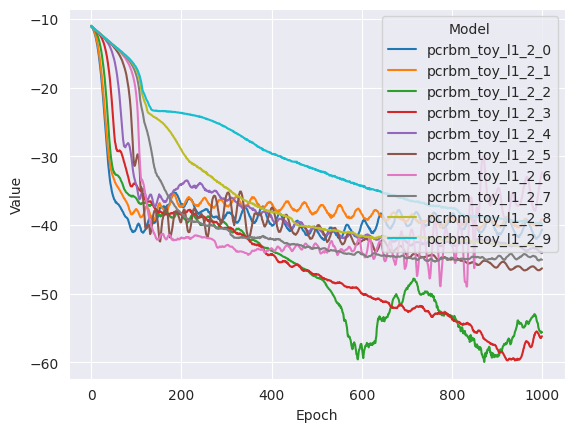

In [28]:
key = 'free_energy_pos'
sns.lineplot(data=df[df['Scalar'] == key], x="Epoch", y="Value", hue="Model")

<Axes: xlabel='Epoch', ylabel='Value'>

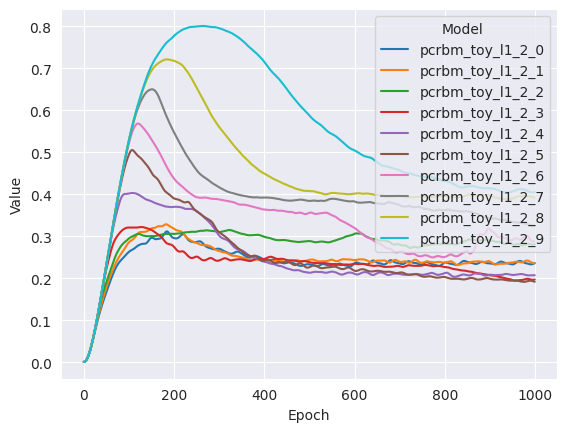

In [29]:
key = 'field_reg'
sns.lineplot(data=df[df['Scalar'] == key], x="Epoch", y="Value", hue="Model")

In [30]:
from rbm_torch.utils import utils

for i in range(len(vrange)):
    # Get checkpoint and directory for latest version of the trained model
    checkp, version_dir = am.get_checkpoint_path(model_configs[i]["model_name"], rbmdir="./trained_crbms/")

    # load crbm
    ncrbm = pool_CRBM.load_from_checkpoint(checkp)
    ncrbm.eval()

    # generate weights inside the latest version directory
    utils.all_weights(ncrbm, name=version_dir + model_configs[i]["model_name"] + "ordered", order_weights=True)

In [6]:
# load data from preconfigured run file
run_file = "./run_files/toy_pcrbm.json"
run_data, base_config = load_run(run_file)

base_config["model_name"] = run_data["model_name"]
base_config["gpus"] = run_data["gpus"]

model_type = run_data["model_type"]
assert model_type == "pool_crbm"

server_model_dir = run_data["server_model_dir"]
base_config['seed'] = 69

import rbm_torch.analysis.analysis_methods as am
from rbm_torch.utils import utils

checkp, version_dir = am.get_checkpoint_path(base_config["model_name"], rbmdir="./trained_crbms/")

# load crbm
ncrbm = pool_CRBM.load_from_checkpoint(checkp)
ncrbm.eval()

# generate weights inside the latest version directory
utils.all_weights(ncrbm, name=version_dir + base_config["model_name"] + "ordered", order_weights=True)

In [4]:
import subprocess as sp

sp.call("mkdir generated", shell=True)
data_key = ["toy_rare"]
all_data = am.fetch_data(data_key, dir="./", assignment_function=None, threads=12)
am.generate_likelihoods(data_key, ncrbm, all_data, "toy_rare_parameter_eval")
likelihoods = am.get_likelihoods("./generated/toy_rare_parameter_eval.json")

mkdir: cannot create directory ‘generated’: File exists


Process Time 0.008468389511108398


<Axes: xlabel='copy_num', ylabel='likelihood'>

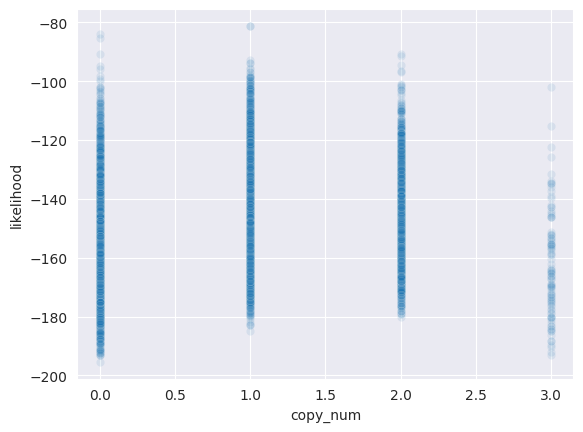

In [33]:
import seaborn as sns

all_data["likelihood"] = likelihoods['likelihoods']['toy_rare']

# sns.stripplot(data=all_data, x="likelihood", hue="copy_num")
sns.scatterplot(data=all_data, x="copy_num", y="likelihood", alpha=0.1)

<Axes: xlabel='copy_num', ylabel='likelihood'>

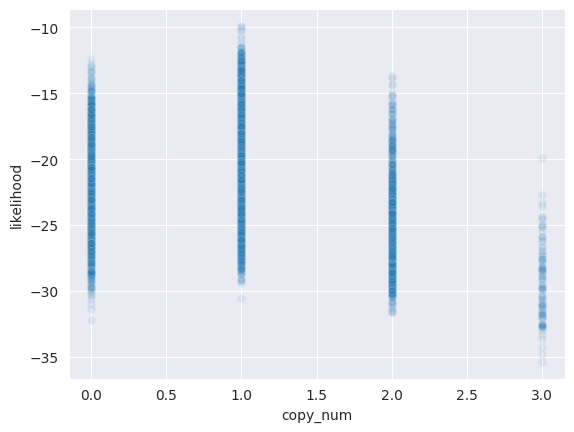

In [5]:
import seaborn as sns

all_data["likelihood"] = likelihoods['likelihoods']['toy_rare']

# sns.stripplot(data=all_data, x="likelihood", hue="copy_num")
sns.scatterplot(data=all_data, x="copy_num", y="likelihood", alpha=0.1)

<Axes: xlabel='copy_num', ylabel='likelihood'>

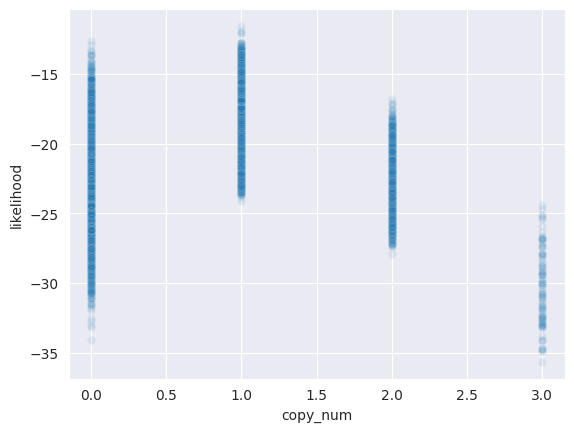

In [36]:
import seaborn as sns

all_data["likelihood"] = likelihoods['likelihoods']['toy_rare']

# sns.stripplot(data=all_data, x="likelihood", hue="copy_num")
sns.scatterplot(data=all_data, x="copy_num", y="likelihood", alpha=0.1)

<Axes: xlabel='copy_num', ylabel='likelihood'>

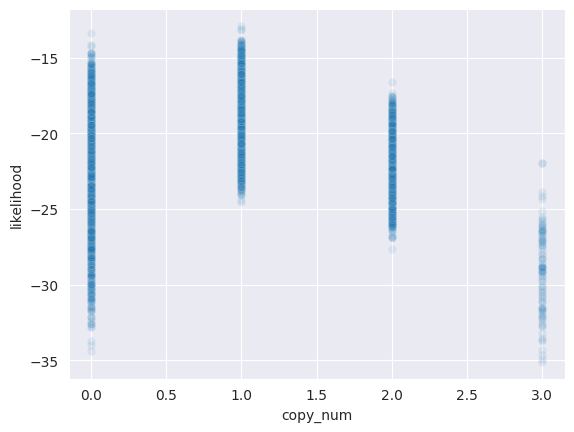

In [8]:
import seaborn as sns

all_data["likelihood"] = likelihoods['likelihoods']['toy_rare']

# sns.stripplot(data=all_data, x="likelihood", hue="copy_num")
sns.scatterplot(data=all_data, x="copy_num", y="likelihood", alpha=0.1)